<a href="https://colab.research.google.com/github/andrefillype19/extractin-tiles/blob/main/Trabalho_de_Processamento_Digital_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importações**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, measure, exposure
from skimage.transform import resize
from skimage.util import invert
from scipy import ndimage
from skimage.io import imsave

**Desenha Bounding Box**

In [2]:
# Função para desenhar caixas delimitadoras ao redor de objetos segmentados
# Argumentos:
#   - original_image: imagem base (pode ser escala de cinza ou colorida)
#   - labeled_image: imagem segmentada com rótulos numéricos para cada objeto
#   - border_color: cor da borda no formato RGB (padrão: vermelho)
#   - border_width: espessura da borda em pixels (padrão: 2)
def draw_bounding_boxes(original_image, labeled_image, border_color=(1, 0, 0), border_width=2):

    # PREPARAÇÃO DA IMAGEM: Converte para RGB e normaliza valores
    if len(original_image.shape) == 2:
        # Se a imagem for escala de cinza (2D), replica o canal para criar RGB
        image_with_boxes = np.stack([original_image]*3, axis=-1)
        # Normaliza valores de pixel para o intervalo 0-1 se necessário
        if image_with_boxes.dtype != float:
            image_with_boxes = image_with_boxes / 255
    else:
        # Se já for colorida, apenas faz uma cópia para não alterar a original
        image_with_boxes = original_image.copy()
        # Normaliza valores de pixel para o intervalo 0-1 se necessário
        if image_with_boxes.dtype != float:
            image_with_boxes = image_with_boxes / 255

    # IDENTIFICAÇÃO DOS OBJETOS: Encontra todos os rótulos únicos
    labels = np.unique(labeled_image)
    # Remove o rótulo 0 (geralmente representa o fundo)
    labels = labels[labels != 0]

    # PROCESSAMENTO DE CADA OBJETO SEGMENTADO
    for label in labels:
        # Encontra todas as coordenadas (linha, coluna) do objeto atual
        coords = np.column_stack(np.where(labeled_image == label))

        # CÁLCULO DOS LIMITES DA CAIXA DELIMITADORA
        # Encontra os pontos extremos do objeto para definir o retângulo
        min_row, min_col = coords.min(axis=0)  # Canto superior esquerdo
        max_row, max_col = coords.max(axis=0)  # Canto inferior direito

        # DESENHO DA BORDA COM ESPESSURA ESPECIFICADA
        for w in range(border_width):
            # Desenha a borda superior (linha horizontal no topo)
            if min_row + w < image_with_boxes.shape[0]:
                image_with_boxes[min_row + w, min_col:max_col+1] = border_color

            # Desenha a borda inferior (linha horizontal embaixo)
            if max_row - w >= 0:
                image_with_boxes[max_row - w, min_col:max_col+1] = border_color

            # Desenha a borda esquerda (linha vertical à esquerda)
            if min_col + w < image_with_boxes.shape[1]:
                image_with_boxes[min_row:max_row+1, min_col + w] = border_color

            # Desenha a borda direita (linha vertical à direita)
            if max_col - w >= 0:
                image_with_boxes[min_row:max_row+1, max_col - w] = border_color

    # Retorna a imagem com as caixas delimitadoras desenhadas
    return image_with_boxes

**Tamanho Proporcional**

In [3]:
# Função para calcular dimensões proporcionais de uma imagem
# Mantém a proporção original (aspect ratio) ao redimensionar
# Argumentos:
#   - image: imagem de entrada (numpy array)
#   - new_width: nova largura desejada em pixels
# Retorna: tupla (nova_altura, nova_largura) mantendo a proporção
def get_proportional_size(image, new_width):
    # EXTRAÇÃO DAS DIMENSÕES ORIGINAIS
    # Pega altura e largura da imagem (funciona para 2D ou 3D)
    # [:2] garante que pega apenas as duas primeiras dimensões
    height, width = image.shape[:2]

    # CÁLCULO DA PROPORÇÃO DE REDIMENSIONAMENTO
    # Calcula o fator de escala baseado na largura
    # Se new_width for menor que width, proportion < 1 (redução)
    # Se new_width for maior que width, proportion > 1 (ampliação)
    proportion = new_width / width

    # CÁLCULO DA NOVA ALTURA PROPORCIONAL
    # Aplica a mesma proporção à altura para manter o aspect ratio
    # int() garante que o resultado seja um número inteiro de pixels
    new_height = int(height * proportion)

    # Retorna as novas dimensões como tupla (altura, largura)
    # Formato compatível com funções de redimensionamento do OpenCV/PIL
    return (new_height, new_width)

**Identifica Cor de Fundo**

In [4]:
# Função para detectar se uma imagem tem fundo escuro baseado na análise ponderada das bordas
# Usa pesos diferentes para cada região da borda, priorizando áreas centrais nas laterais
# Argumentos:
#   - imagem: imagem de entrada (pode ser RGB ou escala de cinza)
#   - limiar: valor limite para considerar um pixel como escuro (padrão: 0.5)
#   - largura_borda: espessura em pixels das bordas a serem analisadas (padrão: 5)
# Retorna: True se o fundo for considerado escuro, False caso contrário
def fundo_escuro_bordas_ponderado(imagem, limiar=0.5, largura_borda=5):

    # CONVERSÃO PARA ESCALA DE CINZA
    # Se a imagem for colorida (3 dimensões), converte para escala de cinza
    if imagem.ndim == 3:
        imagem = color.rgb2gray(imagem)

    # DEFINIÇÃO DAS DIMENSÕES E CENTRO
    height, width = imagem.shape
    # Calcula o centro vertical para usar como referência nos pesos
    centro_y = height // 2

    # EXTRAÇÃO DAS REGIÕES DE BORDA
    # Define as 4 regiões de borda da imagem para análise
    topo = imagem[:largura_borda, :]                    # Primeiras 'largura_borda' linhas
    base = imagem[-largura_borda:, :]                   # Últimas 'largura_borda' linhas
    esquerda = imagem[:, :largura_borda]                # Primeiras 'largura_borda' colunas
    direita = imagem[:, -largura_borda:]                # Últimas 'largura_borda' colunas

    soma_pesos = 0          # Soma total dos pesos aplicados
    soma_ponderada = 0      # Soma ponderada das proporções de pixels escuros

    # ANÁLISE DAS BORDAS HORIZONTAIS (TOPO E BASE)
    # Bordas horizontais recebem peso uniforme (1.0)
    for borda in [topo, base]:
        if borda.size > 0:  # Verifica se a região existe
            # Calcula proporção de pixels escuros na borda
            proporcao_escura = np.sum(borda < limiar) / borda.size
            peso = 1.0  # Peso uniforme para bordas horizontais
            soma_ponderada += proporcao_escura * peso
            soma_pesos += peso

    # ANÁLISE DA BORDA ESQUERDA COM PESO VARIÁVEL
    # Linhas próximas ao centro recebem peso maior
    if esquerda.size > 0:
        for i in range(esquerda.shape[0]):  # Para cada linha da borda esquerda
            linha = esquerda[i, :]
            if linha.size > 0:
                # CÁLCULO DO PESO BASEADO NA DISTÂNCIA DO CENTRO
                # Quanto mais próximo do centro, maior o peso
                distancia_centro = abs(i - centro_y)
                peso = 1.0 / (1.0 + distancia_centro / centro_y)

                # Calcula proporção de pixels escuros na linha atual
                proporcao_escura_linha = np.sum(linha < limiar) / linha.size
                soma_ponderada += proporcao_escura_linha * peso
                soma_pesos += peso

    # ANÁLISE DA BORDA DIREITA COM PESO VARIÁVEL
    # Mesmo sistema de pesos da borda esquerda
    if direita.size > 0:
        for i in range(direita.shape[0]):  # Para cada linha da borda direita
            linha = direita[i, :]
            if linha.size > 0:
                # CÁLCULO DO PESO BASEADO NA DISTÂNCIA DO CENTRO
                # Quanto mais próximo do centro, maior o peso
                distancia_centro = abs(i - centro_y)
                peso = 1.0 / (1.0 + distancia_centro / centro_y)

                # Calcula proporção de pixels escuros na linha atual
                proporcao_escura_linha = np.sum(linha < limiar) / linha.size
                soma_ponderada += proporcao_escura_linha * peso
                soma_pesos += peso

    # CÁLCULO DA PROPORÇÃO FINAL PONDERADA
    # Evita divisão por zero usando operador condicional
    proporcao_ponderada = soma_ponderada / soma_pesos if soma_pesos > 0 else 0

    # DECISÃO FINAL: Retorna True se mais de 50% das bordas são escuras
    return proporcao_ponderada > 0.5


# Função wrapper simplificada para detecção de fundo escuro
# Argumentos: os mesmos da função principal
# Retorna: resultado da análise ponderada das bordas
def fundo_escuro_bordas(imagem, limiar=0.5, largura_borda=5):
    # Chama a função principal com ponderação
    return fundo_escuro_bordas_ponderado(imagem, limiar, largura_borda)

**Pipeline de Processamento**

In [5]:
# Função principal para processar imagem e detectar objetos usando segmentação
# Pipeline completo: carregamento → redimensionamento → binarização → limpeza → detecção
# Argumentos:
#   - image_path: caminho para o arquivo de imagem
#   - show_sizes: se True, exibe as áreas dos objetos detectados (padrão: False)
# Retorna: tupla com 8 elementos (imagem redimensionada, cinza, binária, invertida,
#          rotulada, limpa, com caixas, coordenadas das caixas)
def process_image(image_path, show_sizes=False):

    # CARREGAMENTO E REDIMENSIONAMENTO DA IMAGEM
    # Carrega a imagem original do arquivo
    image = io.imread(image_path)
    # Redimensiona mantendo proporção para largura de 300px (melhora performance)
    resized_image = resize(image, get_proportional_size(image, 300), anti_aliasing=True)

    # CONVERSÃO PARA ESCALA DE CINZA E BINARIZAÇÃO
    # Converte para escala de cinza para facilitar a segmentação
    gray = color.rgb2gray(resized_image)
    # Calcula limiar automático usando método de Otsu (separa objetos do fundo)
    threshold = filters.threshold_otsu(gray)
    # Cria imagem binária: True para pixels escuros, False para claros
    binary = gray < threshold

    # CORREÇÃO DE POLARIDADE BASEADA NO FUNDO
    # Se o fundo não for escuro, inverte a imagem binária
    # Garante que objetos sejam sempre representados como True (branco)
    inverted = invert(binary) if not fundo_escuro_bordas_ponderado(binary) else binary

    # SEGMENTAÇÃO E ROTULAGEM DOS OBJETOS
    # Identifica objetos conectados e atribui rótulos únicos
    labeled_image, _ = ndimage.label(inverted)
    # Extrai propriedades de cada região rotulada (área, centroide, etc.)
    regions = measure.regionprops(labeled_image)

    # FILTRAGEM POR TAMANHO DOS OBJETOS
    # Cria máscara para manter apenas objetos com área adequada
    mask = np.zeros_like(labeled_image)
    for region in regions:
        # Opção de debug: mostra área de cada objeto detectado
        if show_sizes:
            print(region.area)
        # CRITÉRIO DE SELEÇÃO: mantém objetos entre 4000 e 20000 pixels
        # Remove ruído (muito pequenos) e objetos muito grandes (provavelmente fundo)
        if 4000 <= region.area <= 20000:
            mask[labeled_image == region.label] = True

    # APLICAÇÃO DO FILTRO E VISUALIZAÇÕES
    # Aplica a máscara para manter apenas objetos válidos
    cleaned_image = labeled_image * mask
    # Cria visualização colorida sobreposta à imagem original
    colored_regions = color.label2rgb(cleaned_image, image=resized_image, bg_label=0, alpha=0.5)
    # Desenha caixas delimitadoras ao redor dos objetos detectados
    boxed = draw_bounding_boxes(resized_image, cleaned_image)

    # CÁLCULO DAS COORDENADAS NORMALIZADAS DAS CAIXAS
    # Obtém dimensões da imagem para normalização
    image_height, image_width = resized_image.shape[:2]
    bboxes = []

    # Para cada objeto limpo, calcula coordenadas no formato YOLO
    for region in measure.regionprops(cleaned_image):
        # Extrai coordenadas da caixa delimitadora (bbox)
        minr, minc, maxr, maxc = region.bbox

        # CONVERSÃO PARA FORMATO YOLO (valores entre 0 e 1)
        # Centro da caixa normalizado
        center_x = (minc + maxc) / 2 / image_width
        center_y = (minr + maxr) / 2 / image_height
        # Dimensões da caixa normalizadas
        width = (maxc - minc) / image_width
        height = (maxr - minr) / image_height

        # Formato: (classe, centro_x, centro_y, largura, altura)
        # Classe 0 = objeto genérico detectado
        bboxes.append((0, center_x, center_y, width, height))

    # RETORNO DE TODOS OS ESTÁGIOS DO PROCESSAMENTO
    # Permite análise detalhada de cada etapa do pipeline
    return (
        resized_image,    # Imagem original redimensionada
        gray,            # Versão em escala de cinza
        binary,          # Imagem binarizada inicial
        inverted,        # Imagem com polaridade corrigida
        labeled_image,   # Todos os objetos rotulados
        cleaned_image,   # Apenas objetos filtrados por tamanho
        boxed,          # Imagem com caixas delimitadoras
        bboxes          # Coordenadas normalizadas das caixas
    )

**Plotar Imagens**

In [6]:
# Função para visualizar múltiplas imagens em uma única linha horizontal
# Útil para comparar diferentes estágios de processamento lado a lado
# Argumentos:
#   - imagens: lista de arrays numpy representando as imagens
#   - titulos: lista de strings com os títulos de cada imagem
#   - tamanho: tupla (largura, altura) definindo o tamanho da figura (padrão: 24x5)
def plotar_imagens_em_linha(imagens, titulos, tamanho=(24, 5)):

    # CONFIGURAÇÃO INICIAL DA VISUALIZAÇÃO
    # Conta o número total de imagens a serem exibidas
    n = len(imagens)
    # Cria uma nova figura com o tamanho especificado
    plt.figure(figsize=tamanho)

    # ITERAÇÃO E PLOTAGEM DE CADA IMAGEM
    for i, img in enumerate(imagens):

        # SELEÇÃO AUTOMÁTICA DO MAPA DE CORES
        # Determina se deve usar escala de cinza baseado no título
        # Detecta palavras-chave que indicam imagens monocromáticas
        cmap = 'gray' if titulos[i].lower() in ("gray", "binary", "inverted binary") else None

        # CONFIGURAÇÃO DO SUBPLOT
        # Cria subplot na posição i+1 (matplotlib usa indexação 1-based)
        # Layout: 1 linha, n colunas, posição atual i+1
        plt.subplot(1, n, i + 1)

        # EXIBIÇÃO DA IMAGEM
        # Mostra a imagem com o mapa de cores apropriado
        # cmap=None permite que matplotlib use cores naturais para imagens RGB
        plt.imshow(img, cmap=cmap)

        # CONFIGURAÇÃO DA APRESENTAÇÃO
        # Remove eixos (números e marcações) para visualização limpa
        plt.axis('off')
        # Define o título acima de cada imagem
        plt.title(titulos[i])

    # AJUSTES FINAIS DE LAYOUT
    # Ajusta automaticamente o espaçamento entre subplots
    # Evita sobreposição de títulos e imagens
    plt.tight_layout()

    # EXIBIÇÃO DA FIGURA COMPLETA
    # Renderiza todas as imagens na tela
    plt.show()

**Salvar Saídas**

In [7]:
# Função para salvar todos os resultados do processamento de imagem
# Cria estrutura de diretórios e salva imagens individuais, composição e coordenadas
# Argumentos:
#   - resultados: tupla com 8 elementos retornados pela função process_image()
#   - image_path: caminho da imagem original processada
#   - output_base: diretório base para salvar os resultados (padrão: "Process Output")
def save_output(resultados, image_path, output_base="Process Output"):

    # DESEMPACOTAMENTO DOS RESULTADOS DO PROCESSAMENTO
    # Extrai todas as 8 etapas do pipeline de processamento
    (
        resized_image,    # Imagem original redimensionada
        gray,            # Versão em escala de cinza
        binary,          # Imagem binarizada
        inverted,        # Imagem com polaridade corrigida
        labeled_image,   # Objetos rotulados
        cleaned_image,   # Objetos filtrados
        boxed,          # Imagem com caixas delimitadoras
        bboxes          # Coordenadas das caixas (formato YOLO)
    ) = resultados

    # CONFIGURAÇÃO DO DIRETÓRIO DE SAÍDA
    # Extrai nome do arquivo sem extensão
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    # Cria subdiretório específico para esta imagem
    output_dir = os.path.join(output_base, image_name)
    # Cria diretório se não existir (exist_ok evita erro se já existir)
    os.makedirs(output_dir, exist_ok=True)

    # PREPARAÇÃO DAS IMAGENS PARA SALVAMENTO
    # Lista com todas as imagens a serem salvas individualmente
    imagens_para_salvar = [
        resized_image,                           # Imagem original redimensionada
        gray,                                   # Escala de cinza
        binary,                                 # Binária original
        inverted,                              # Binária invertida
        (labeled_image > 0).astype(float),     # Máscara de objetos rotulados
        (cleaned_image > 0).astype(float),     # Máscara de objetos filtrados
        boxed                                  # Imagem com caixas delimitadoras
    ]

    # TÍTULOS CORRESPONDENTES PARA CADA IMAGEM
    titulos = [
        "Resized Image", "Gray", "Binary", "Inverted Binary",
        "Labeled Image", "Cleaned Image", "Bounding Boxes"
    ]

    # IMPORTAÇÕES NECESSÁRIAS PARA SALVAMENTO
    from skimage.io import imsave
    import numpy as np

    # SALVAMENTO INDIVIDUAL DE CADA IMAGEM
    for img, title in zip(imagens_para_salvar, titulos):
        # Gera nome do arquivo substituindo espaços por underscores
        save_path = os.path.join(output_dir, f"{image_name}_{title.replace(' ', '_')}.png")

        # CONVERSÃO DE TIPO DE DADOS PARA SALVAMENTO
        # Verifica se a imagem está em formato float (0-1)
        if img.dtype in [np.float32, np.float64]:
            if img.ndim == 3 and img.shape[2] == 3:
                # IMAGEM COLORIDA: normaliza [0,1] e converte para uint8 [0,255]
                img_to_save = (np.clip(img, 0, 1) * 255).astype(np.uint8)
            else:
                # IMAGEM ESCALA DE CINZA: mesma conversão float->uint8
                img_to_save = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        else:
            # Se já estiver em formato adequado, usa diretamente
            img_to_save = img

        # Salva a imagem no disco
        imsave(save_path, img_to_save)

    # CRIAÇÃO DA IMAGEM COMPOSTA (GRADE 3x3)
    import matplotlib.pyplot as plt
    # Cria figura com grade 3x3 para mostrar todas as etapas
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    # Converte matriz 2D de subplots em array 1D para fácil indexação
    axs = axs.flatten()

    # PREENCHIMENTO DA GRADE COM AS IMAGENS
    for i in range(9):  # 9 posições na grade 3x3
        # Remove eixos de todos os subplots
        axs[i].axis('off')

        # Preenche apenas as posições que têm imagens correspondentes
        if i < len(imagens_para_salvar):
            # SELEÇÃO AUTOMÁTICA DO MAPA DE CORES
            # Usa escala de cinza para imagens binárias e em tons de cinza
            if titulos[i].lower().find('gray') != -1 or titulos[i].lower().find('binary') != -1:
                cmap = 'gray'
            else:
                cmap = None

            # Exibe a imagem no subplot
            axs[i].imshow(imagens_para_salvar[i], cmap=cmap)
            # Define título com fonte menor para caber na grade
            axs[i].set_title(titulos[i], fontsize=12)

    # SALVAMENTO DA IMAGEM COMPOSTA
    plt.tight_layout()  # Ajusta espaçamento automático
    output_path = os.path.join(output_dir, f"{image_name}_Output.png")
    plt.savefig(output_path)  # Salva a figura completa
    plt.close(fig)  # Libera memória fechando a figura

    # SALVAMENTO DO ARQUIVO DE ANOTAÇÕES (FORMATO YOLO)
    # Cria arquivo .txt com coordenadas das caixas delimitadoras
    txt_path = os.path.join(output_dir, f"{image_name}.txt")
    with open(txt_path, "w") as f:
        # Para cada caixa detectada, escreve uma linha no formato YOLO
        for bbox in bboxes:
            # Formato: classe centro_x centro_y largura altura (16 casas decimais)
            # bbox = (classe, centro_x, centro_y, largura, altura)
            f.write(f"0 {bbox[1]:.16f} {bbox[2]:.16f} {bbox[3]:.16f} {bbox[4]:.16f}\n")

**Main**


Processando: WhatsApp Image 2024-04-26 at 2.36.24 PM (1).jpeg


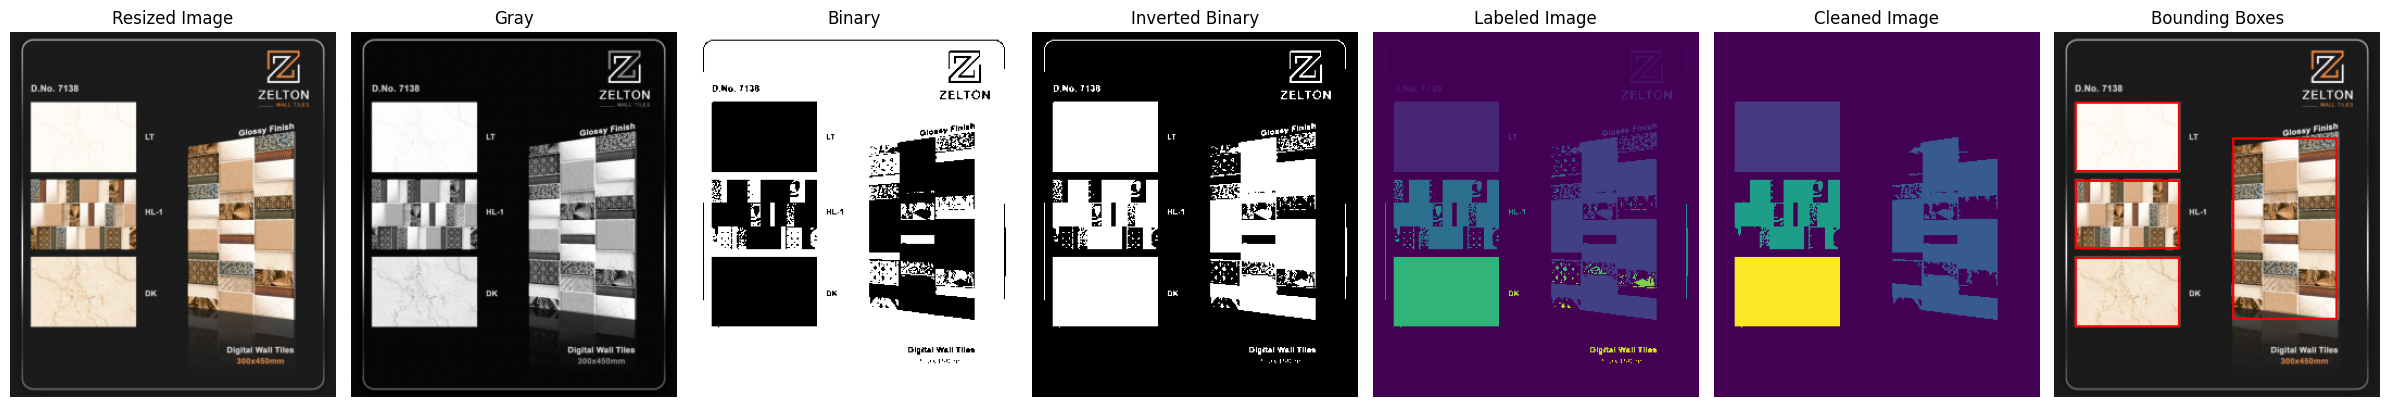

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-26 at 2.36.24 PM (1)/WhatsApp Image 2024-04-26 at 2.36.24 PM (1)_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-26 at 2.36.24 PM (1)/WhatsApp Image 2024-04-26 at 2.36.24 PM (1)_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: WhatsApp Image 2023-05-17 at 4.25.49 PM.jpeg


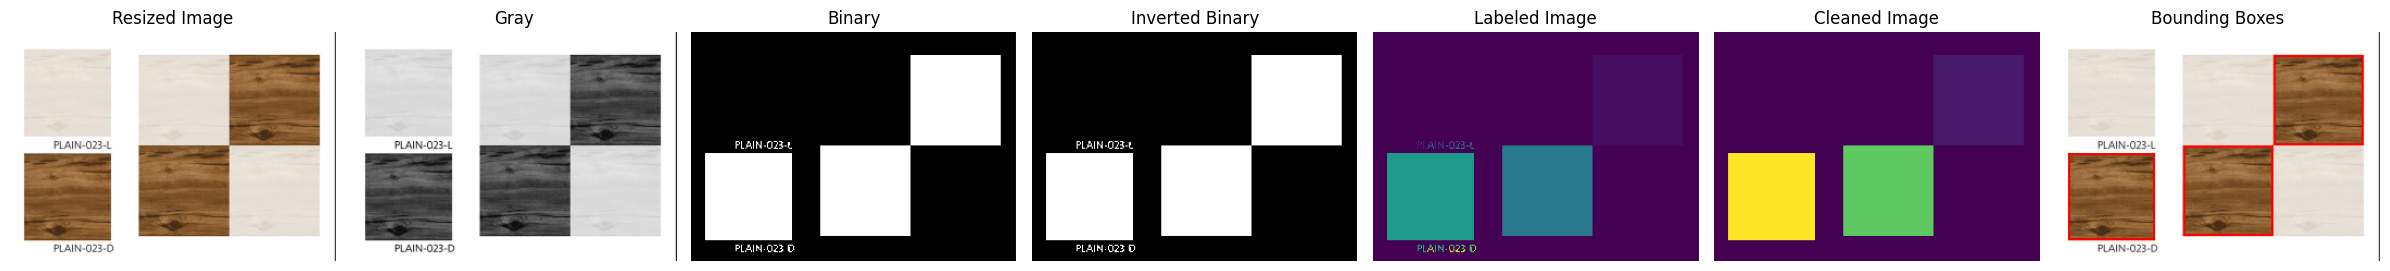

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2023-05-17 at 4.25.49 PM/WhatsApp Image 2023-05-17 at 4.25.49 PM_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2023-05-17 at 4.25.49 PM/WhatsApp Image 2023-05-17 at 4.25.49 PM_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: Screenshot_20231005_130808_Samsung Notes.jpg


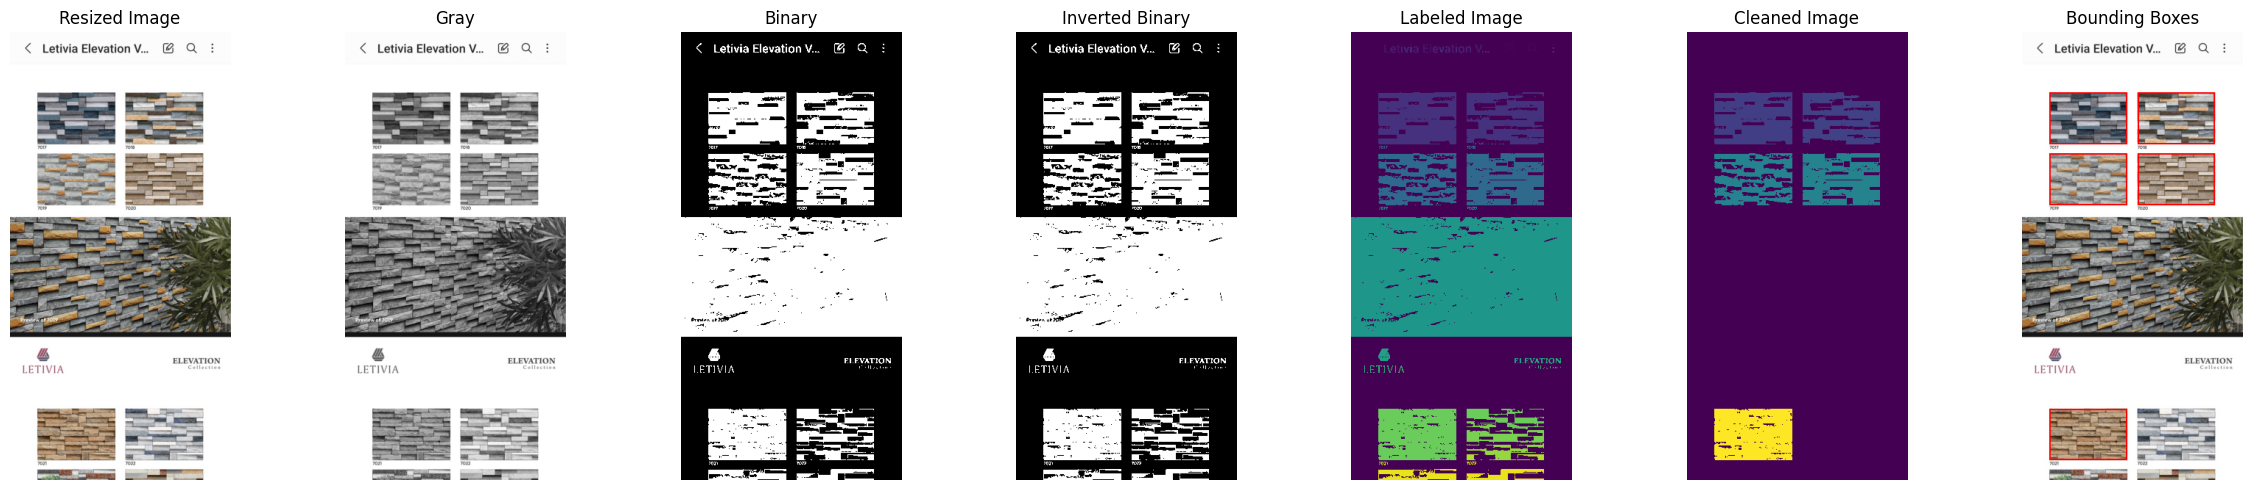

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/Screenshot_20231005_130808_Samsung Notes/Screenshot_20231005_130808_Samsung Notes_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/Screenshot_20231005_130808_Samsung Notes/Screenshot_20231005_130808_Samsung Notes_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: WhatsApp Image 2024-04-26 at 2.36.25 PM (1).jpeg


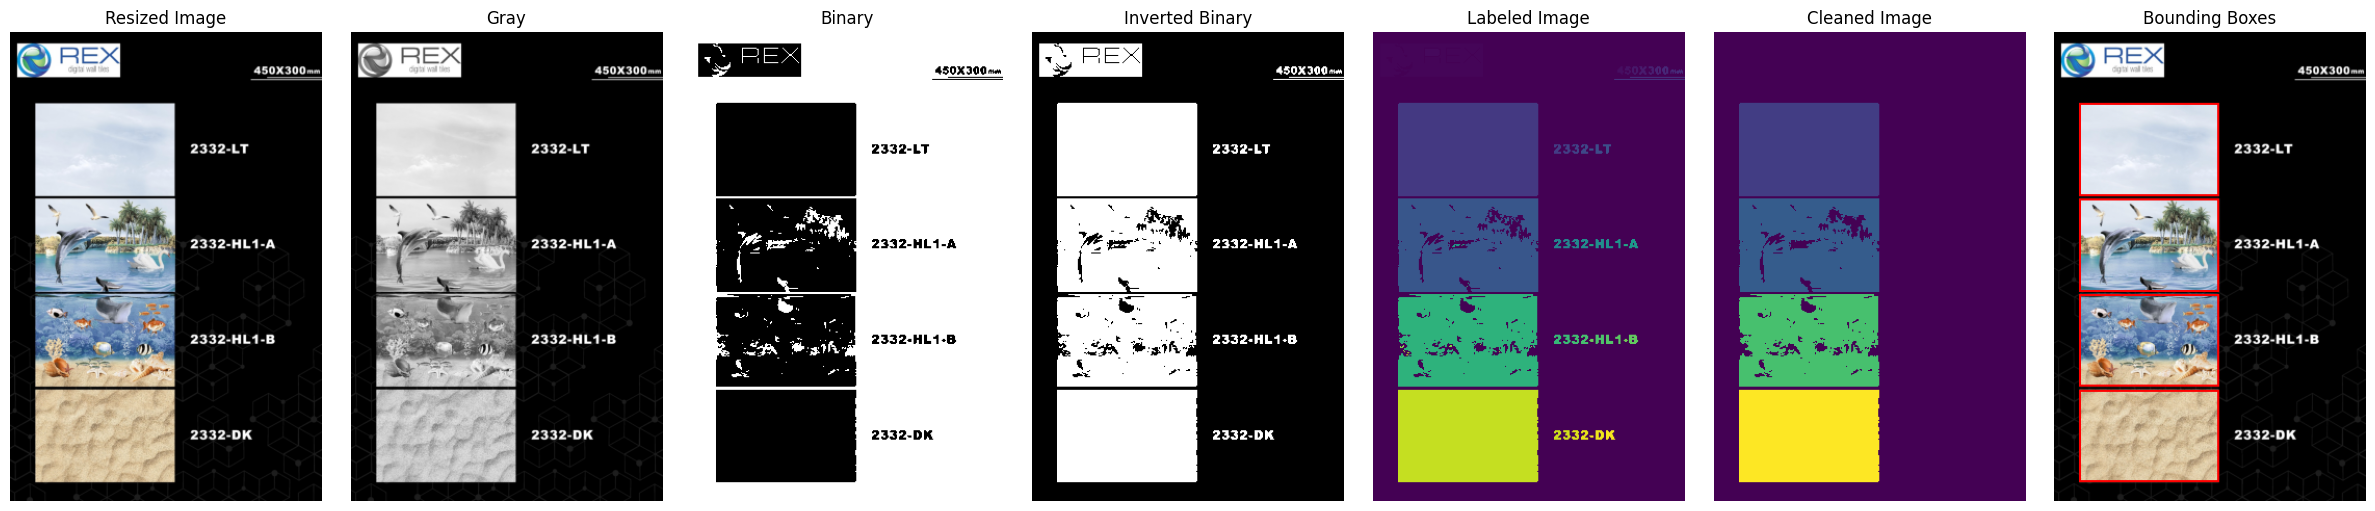

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-26 at 2.36.25 PM (1)/WhatsApp Image 2024-04-26 at 2.36.25 PM (1)_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-26 at 2.36.25 PM (1)/WhatsApp Image 2024-04-26 at 2.36.25 PM (1)_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: WhatsApp Image 2024-04-09 at 8.39.21 AM (2).jpeg


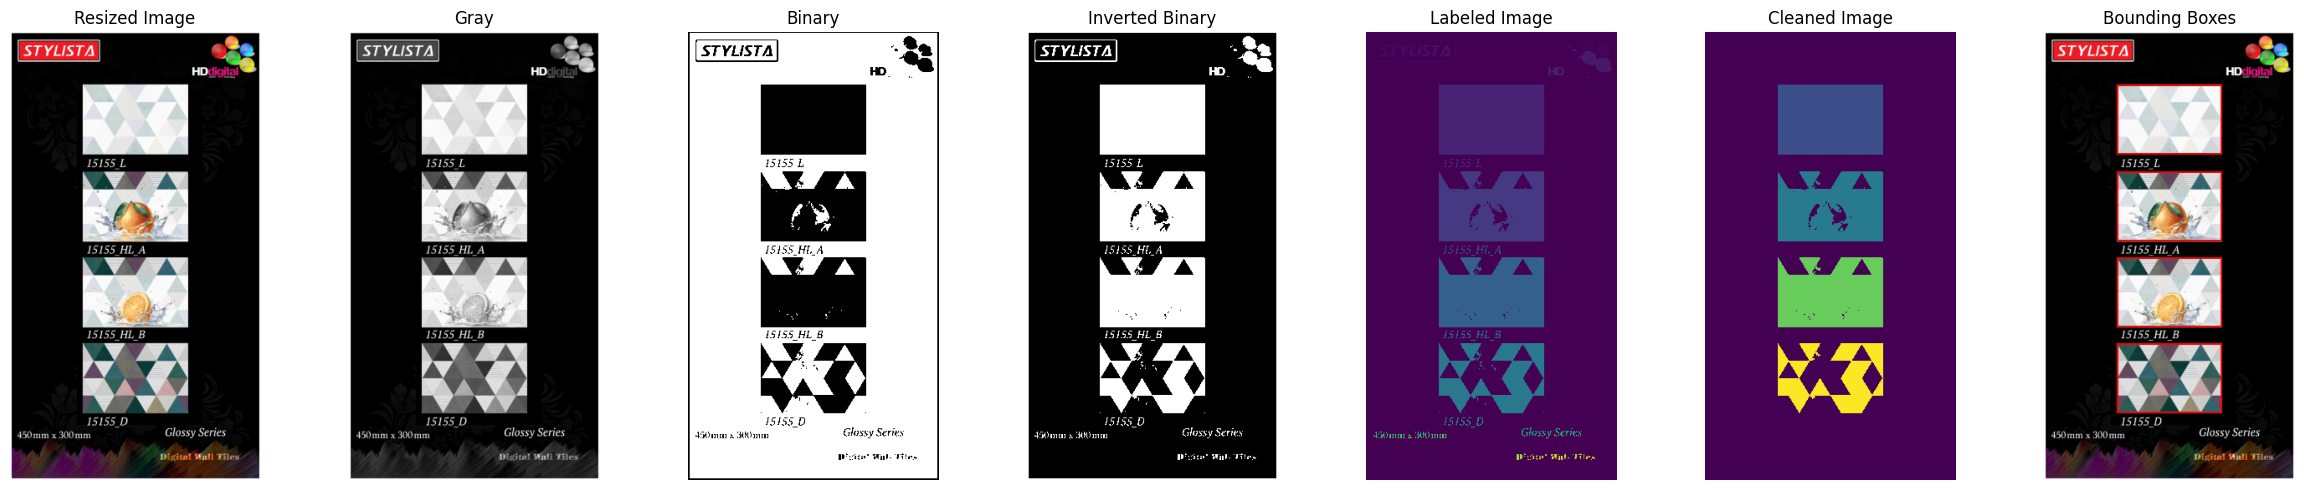

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-09 at 8.39.21 AM (2)/WhatsApp Image 2024-04-09 at 8.39.21 AM (2)_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-09 at 8.39.21 AM (2)/WhatsApp Image 2024-04-09 at 8.39.21 AM (2)_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: WhatsApp Image 2024-04-26 at 2.36.24 PM.jpeg


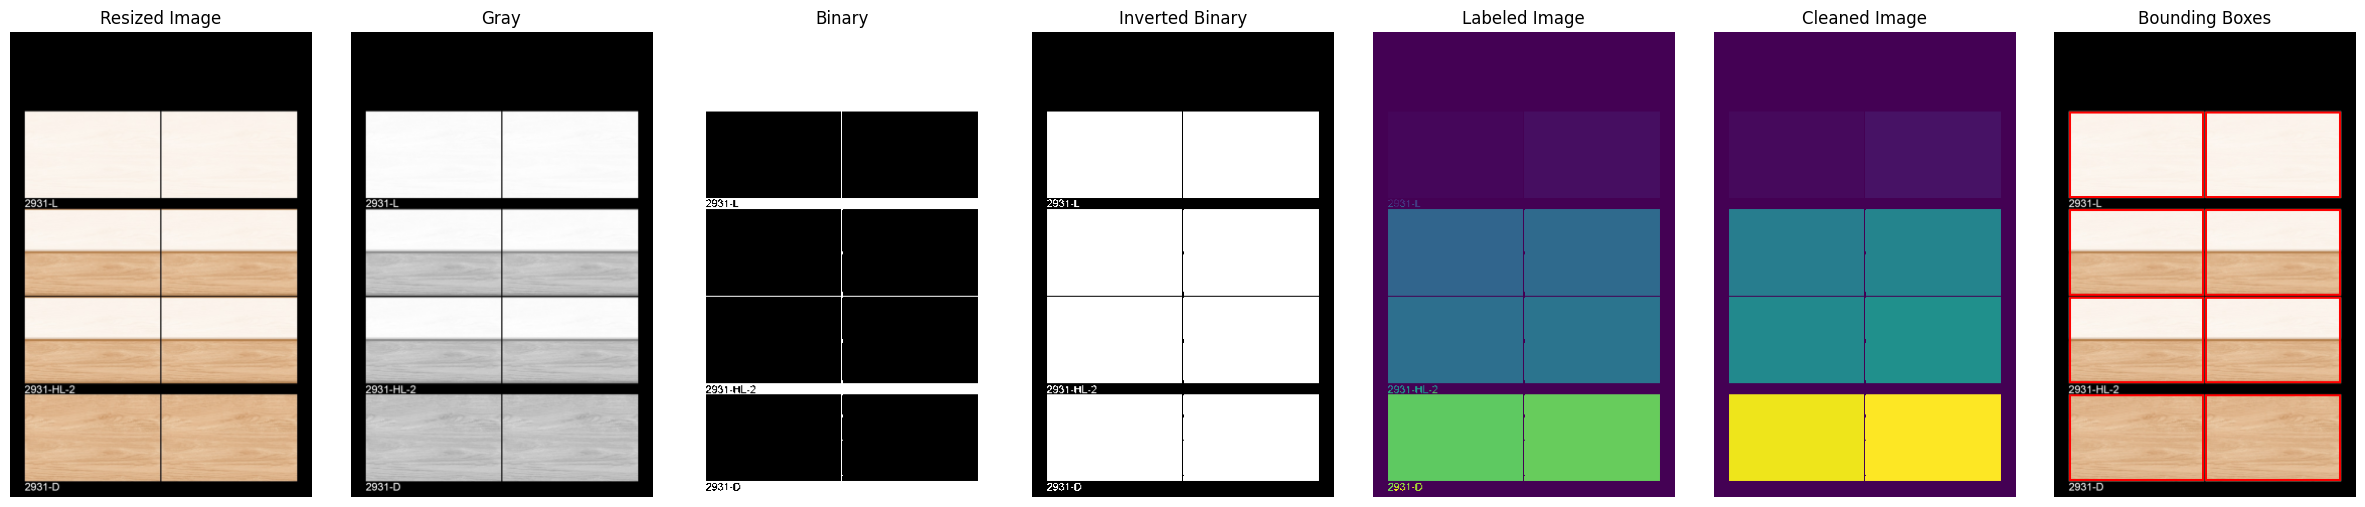

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-26 at 2.36.24 PM/WhatsApp Image 2024-04-26 at 2.36.24 PM_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-26 at 2.36.24 PM/WhatsApp Image 2024-04-26 at 2.36.24 PM_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: WhatsApp Image 2023-05-17 at 4.25.49 PM (1).jpeg


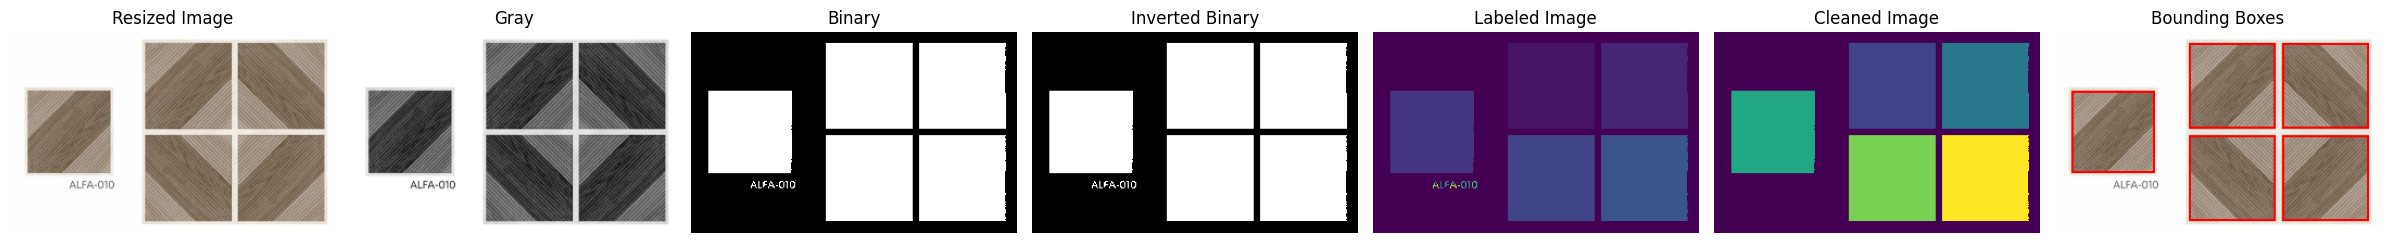

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2023-05-17 at 4.25.49 PM (1)/WhatsApp Image 2023-05-17 at 4.25.49 PM (1)_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2023-05-17 at 4.25.49 PM (1)/WhatsApp Image 2023-05-17 at 4.25.49 PM (1)_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: inbound7032073533058753026.jpg


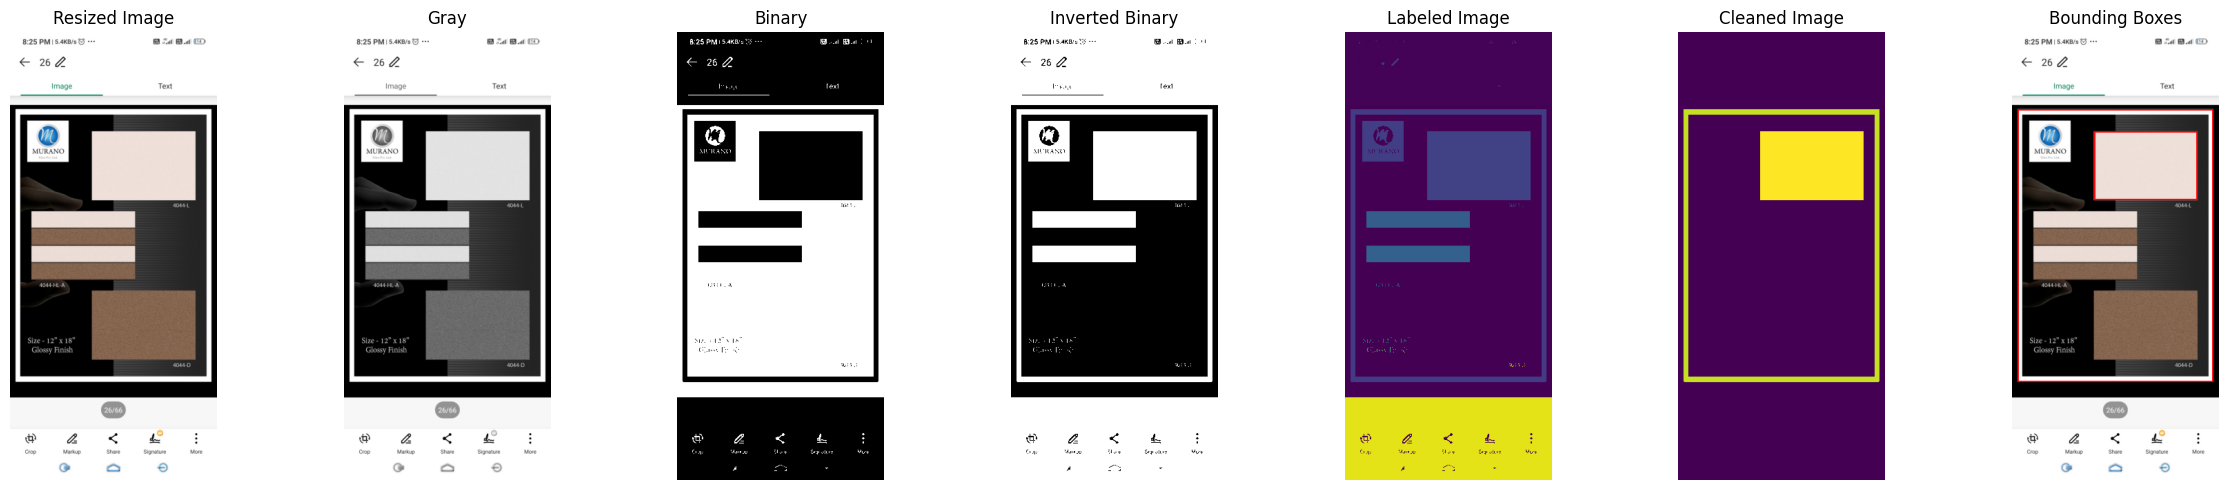

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/inbound7032073533058753026/inbound7032073533058753026_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/inbound7032073533058753026/inbound7032073533058753026_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: WhatsApp Image 2024-04-09 at 8.39.21 AM.jpeg


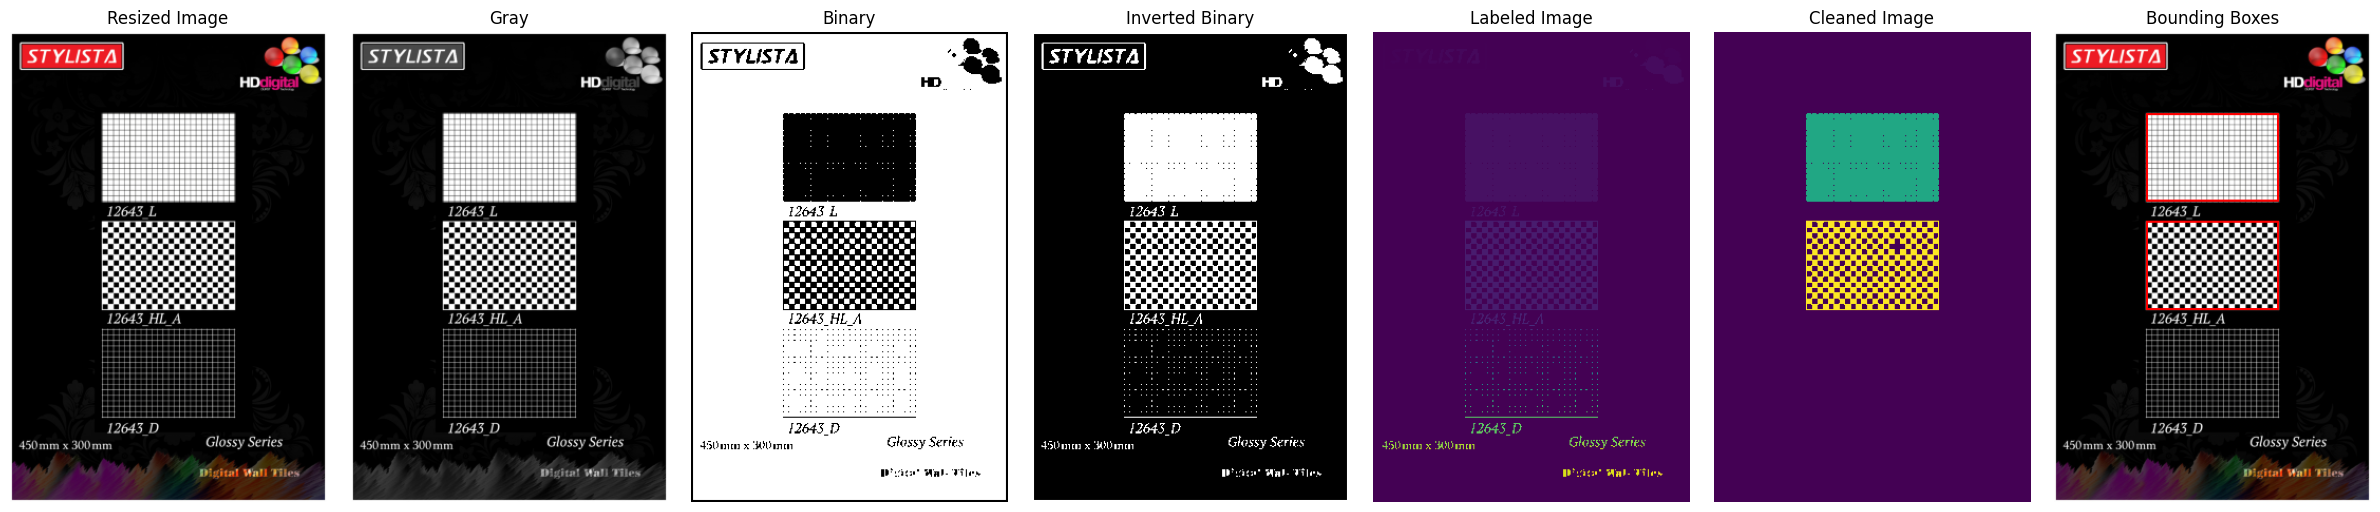

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-09 at 8.39.21 AM/WhatsApp Image 2024-04-09 at 8.39.21 AM_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-09 at 8.39.21 AM/WhatsApp Image 2024-04-09 at 8.39.21 AM_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: inbound2046248303897585640.jpg


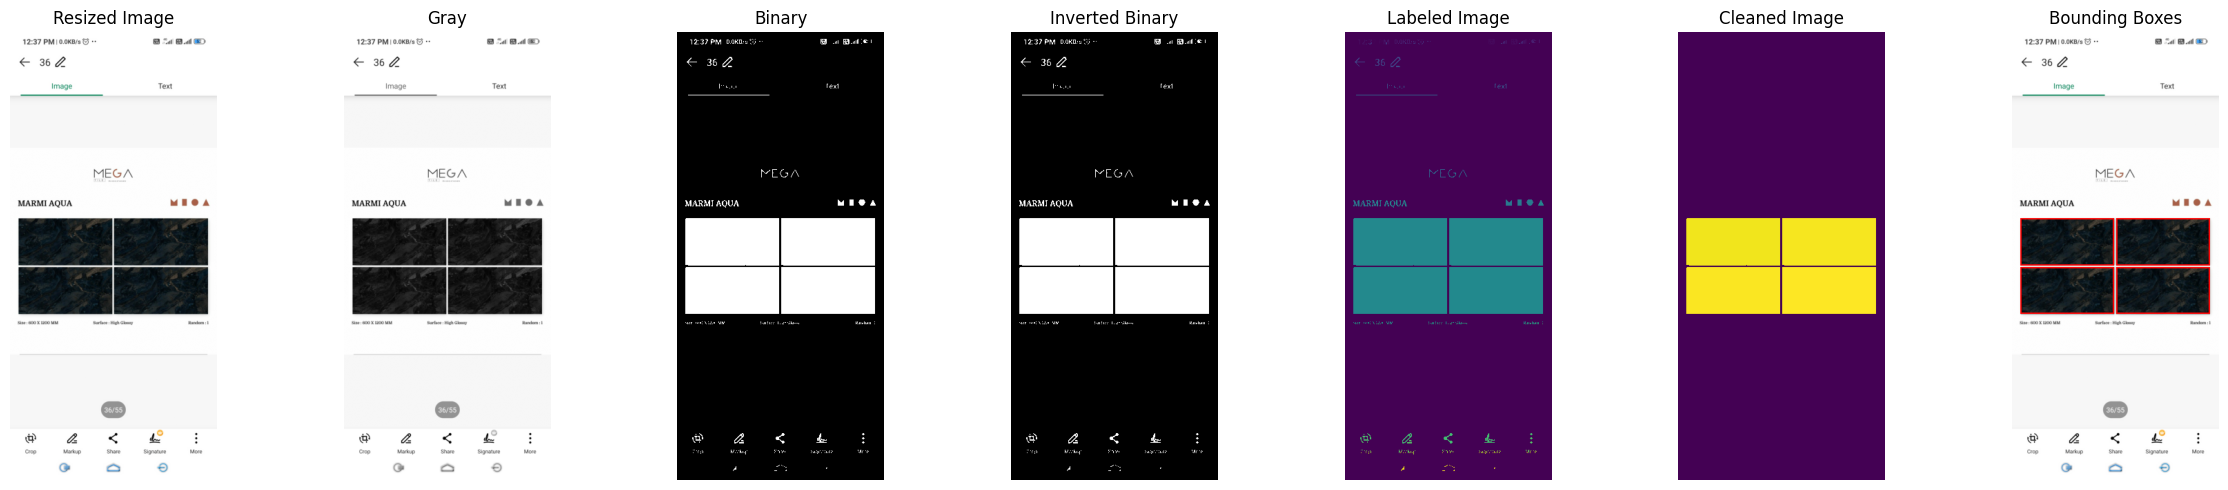

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/inbound2046248303897585640/inbound2046248303897585640_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/inbound2046248303897585640/inbound2046248303897585640_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)



Processando: WhatsApp Image 2024-04-09 at 8.39.21 AM (1).jpeg


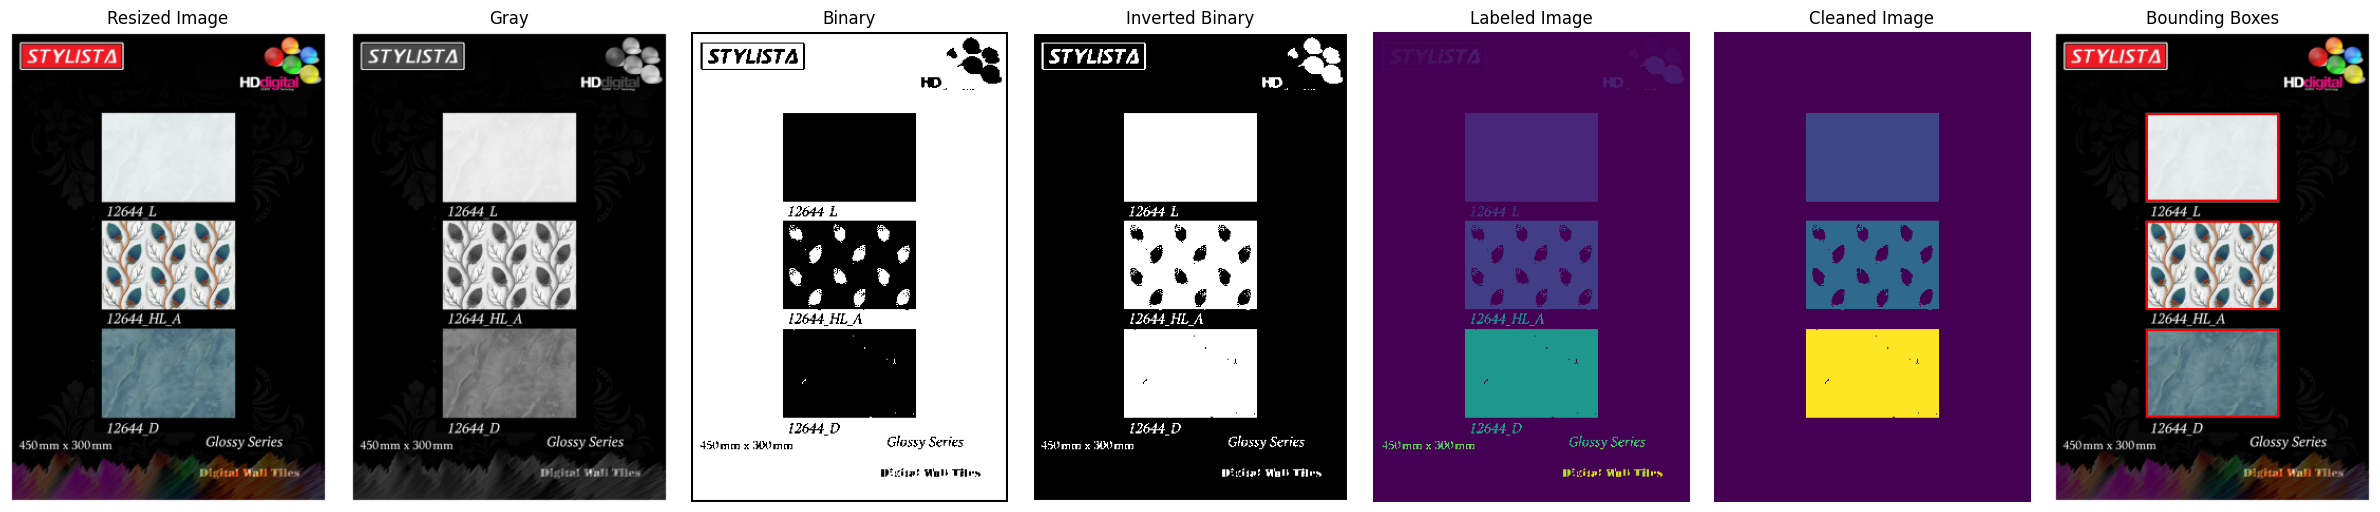

/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-09 at 8.39.21 AM (1)/WhatsApp Image 2024-04-09 at 8.39.21 AM (1)_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)
/tmp/ipython-input-7-267527968.py:71: UserWarning: Process Output/WhatsApp Image 2024-04-09 at 8.39.21 AM (1)/WhatsApp Image 2024-04-09 at 8.39.21 AM (1)_Inverted_Binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(save_path, img_to_save)


In [8]:
if __name__ == "__main__":
    # Define o diretório onde estão armazenadas as imagens a serem processadas
    pasta_imagens = "Images"

    # Lista todos os arquivos da pasta e filtra apenas imagens com extensões válidas
    # Usa .lower() para tornar a verificação case-insensitive (aceita .PNG, .Png, etc.)
    imagens = [f for f in os.listdir(pasta_imagens) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    # Loop para processar cada imagem encontrada na pasta
    for nome_arquivo in imagens:
        # Constrói o caminho completo do arquivo de forma segura e multiplataforma
        caminho = os.path.join(pasta_imagens, nome_arquivo)

        # Exibe o nome do arquivo que está sendo processado
        print(f"\nProcessando: {nome_arquivo}")

        # Executa o pipeline de processamento da imagem
        # A função process_image() retorna uma lista com os resultados de cada etapa
        resultados = process_image(caminho)

        # Visualiza os primeiros 7 resultados do processamento em uma linha
        plotar_imagens_em_linha(
            resultados[:7],  # Pega apenas os primeiros 7 resultados
            titulos=(
                "Resized Image",     # Imagem redimensionada
                "Gray",              # Conversão para escala de cinza
                "Binary",            # Binarização (preto e branco)
                "Inverted Binary",   # Binarização invertida
                "Labeled Image",     # Imagem com componentes rotulados
                "Cleaned Image",     # Imagem após limpeza/filtragem
                "Bounding Boxes"     # Imagem com caixas delimitadoras
            ),
            tamanho=(24, 5)  # Define o tamanho da figura (largura=24, altura=5)
        )

        # Salva os resultados do processamento
        # Provavelmente salva as imagens processadas ou dados extraídos
        save_output(resultados, caminho)

**Baixar Process Output**

In [9]:
from google.colab import files
import shutil

shutil.make_archive('Process Output', 'zip', 'Process Output')
files.download('Process Output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>